In [1]:
# Install NBA API
!pip install nba_api

In [3]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.stats import norm, gaussian_kde, percentileofscore
import matplotlib.pyplot as plt

from nba_api.stats.static import players
from nba_api.stats.endpoints import shotchartdetail
from nba_api.stats.endpoints import playercareerstats

from matplotlib import cm
from matplotlib.patches import Circle, Rectangle, Arc, ConnectionPatch
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, BoundaryNorm
from matplotlib.path import Path
from matplotlib.patches import PathPatch
import seaborn as sns

sns.set_style('white')
sns.set_color_codes()


# Shot Chart Detail Function

In [4]:
def get_player_shotchartdetail(player_name, season_id):
    """
    Parameters
    ----------
    player_name: name of the player with capital letter
    season_id: ex. 2012-13
    """
    # Player Dictionary
    nba_players = players.get_players()
    player_dict = [player for player in nba_players if player['full_name'] == player_name][0]

    # Career DataFrame
    career = playercareerstats.PlayerCareerStats(player_id=player_dict['id'])
    career_df = career.get_data_frames()[0]

    # Team ID During Season
    team_id = career_df[career_df['SEASON_ID'] == season_id]['TEAM_ID']

    # Shot Chart Detail Endpoint
    shotchartlist = shotchartdetail.ShotChartDetail(team_id=int(team_id),
                                                    player_id=int(player_dict['id']),
                                                    season_type_all_star='Regular Season',
                                                    season_nullable=season_id,
                                                    context_measure_simple='FGA').get_data_frames()
    return shotchartlist[0], shotchartlist[1]

# Lauri Markkanen Shot Chart, 2021-22 Season

In [5]:
player_shotchart_df, league_avg = get_player_shotchartdetail('Lauri Markkanen', '2021-22')

In [6]:
player_shotchart_df.head()

,GRID_TYPE,GAME_ID,GAME_EVENT_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,PERIOD,MINUTES_REMAINING,SECONDS_REMAINING,...,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_ATTEMPTED_FLAG,SHOT_MADE_FLAG,GAME_DATE,HTM,VTM
0,Shot Chart Detail,0022100007,16,1628374,Lauri Markkanen,1610612739,Cleveland Cavaliers,1,10,43,...,Center(C),Less Than 8 ft.,7,-48,62,1,0,20211020,MEM,CLE
1,Shot Chart Detail,0022100007,23,1628374,Lauri Markkanen,1610612739,Cleveland Cavaliers,1,9,47,...,Left Side(L),24+ ft.,22,-229,17,1,0,20211020,MEM,CLE
2,Shot Chart Detail,0022100007,76,1628374,Lauri Markkanen,1610612739,Cleveland Cavaliers,1,5,48,...,Center(C),Less Than 8 ft.,5,56,18,1,1,20211020,MEM,CLE
3,Shot Chart Detail,0022100007,180,1628374,Lauri Markkanen,1610612739,Cleveland Cavaliers,2,10,11,...,Center(C),Less Than 8 ft.,3,-31,13,1,0,20211020,MEM,CLE
4,Shot Chart Detail,0022100007,183,1628374,Lauri Markkanen,1610612739,Cleveland Cavaliers,2,10,4,...,Center(C),Less Than 8 ft.,0,0,0,1,0,20211020,MEM,CLE


In [7]:
league_avg.head()

,GRID_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,FGA,FGM,FG_PCT
0,League Averages,Above the Break 3,Back Court(BC),Back Court Shot,35,4,0.114
1,League Averages,Above the Break 3,Center(C),24+ ft.,16368,5613,0.343
2,League Averages,Above the Break 3,Left Side Center(LC),24+ ft.,24924,8511,0.341
3,League Averages,Above the Break 3,Right Side Center(RC),24+ ft.,23120,8171,0.353
4,League Averages,Backcourt,Back Court(BC),Back Court Shot,440,11,0.025


# Draw Basketball Court Function

In [8]:
# Basketball Court Function
def draw_court(ax=None, color="blue", lw=1, shotzone=False, outer_lines=False):
    """Returns an axes with a basketball court drawn onto to it.
    This function draws a court based on the x and y-axis values that the NBA
    stats API provides for the shot chart data.  For example the center of the
    hoop is located at the (0,0) coordinate.  Twenty-two feet from the left of
    the center of the hoop in is represented by the (-220,0) coordinates.
    So one foot equals +/-10 units on the x and y-axis.
    Parameters
    ----------
    ax : Axes, optional
        The Axes object to plot the court onto.
    color : matplotlib color, optional
        The color of the court lines.
    lw : float, optional
        The linewidth the of the court lines.
    outer_lines : boolean, optional
        If `True` it draws the out of bound lines in same style as the rest of
        the court.
    Returns
    -------
    ax : Axes
        The Axes object with the court on it.
    """
    if ax is None:
        ax = plt.gca()

    # Create the various parts of an NBA basketball court

    # Create the basketball hoop
    hoop = Circle((0, 0), radius=7.5, linewidth=lw, color=color, fill=False)

    # Create backboard
    backboard = Rectangle((-30, -12.5), 60, 0, linewidth=lw, color=color)

    # The paint
    # Create the outer box 0f the paint, width=16ft, height=19ft
    outer_box = Rectangle((-80, -47.5), 160, 190, linewidth=lw, color=color,
                          fill=False)
    # Create the inner box of the paint, widt=12ft, height=19ft
    inner_box = Rectangle((-60, -47.5), 120, 190, linewidth=lw, color=color,
                          fill=False)

    # Create free throw top arc
    top_free_throw = Arc((0, 142.5), 120, 120, theta1=0, theta2=180,
                         linewidth=lw, color=color, fill=False)
    # Create free throw bottom arc
    bottom_free_throw = Arc((0, 142.5), 120, 120, theta1=180, theta2=0,
                            linewidth=lw, color=color, linestyle='dashed')
    # Restricted Zone, it is an arc with 4ft radius from center of the hoop
    restricted = Arc((0, 0), 80, 80, theta1=0, theta2=180, linewidth=lw,
                     color=color)

    # Three point line
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_a = Rectangle((-220, -47.5), 0, 140, linewidth=lw,
                               color=color)
    # Create the right side 3pt lines, it's 14ft long before it arcs
    corner_three_b = Rectangle((220, -47.5), 0, 140, linewidth=lw, color=color)
    # 3pt arc - center of arc will be the hoop, arc is 23'9" away from hoop
    three_arc = Arc((0, 0), 475, 475, theta1=22, theta2=158, linewidth=lw,
                    color=color)

    # Center Court
    center_outer_arc = Arc((0, 422.5), 120, 120, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    center_inner_arc = Arc((0, 422.5), 40, 40, theta1=180, theta2=0,
                           linewidth=lw, color=color)
    
    # Draw shotzone Lines
    # Based on Advanced Zone Mode
    if (shotzone == True):
        inner_circle = Circle((0, 0), radius=80, linewidth=lw, color='black', fill=False)
        outer_circle = Circle((0, 0), radius=160, linewidth=lw, color='black', fill=False)
        corner_three_a_x =  Rectangle((-250, 92.5), 30, 0, linewidth=lw, color=color)
        corner_three_b_x = Rectangle((220, 92.5), 30, 0, linewidth=lw, color=color)
        
        # 60 degrees
        inner_line_1 = Rectangle((40, 69.28), 80, 0, 60, linewidth=lw, color=color)
        # 120 degrees
        inner_line_2 = Rectangle((-40, 69.28), 80, 0, 120, linewidth=lw, color=color)
        
        # Assume x distance is also 40 for the endpoint
        inner_line_3 = Rectangle((53.20, 150.89), 290, 0, 70.53, linewidth=lw, color=color)
        inner_line_4 = Rectangle((-53.20, 150.89), 290, 0, 109.47, linewidth=lw, color=color)
        
        # Assume y distance is also 92.5 for the endpoint
        inner_line_5 = Rectangle((130.54, 92.5), 80, 0, 35.32, linewidth=lw, color=color)
        inner_line_6 = Rectangle((-130.54, 92.5), 80, 0, 144.68, linewidth=lw, color=color)
        
        
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc, inner_circle, outer_circle,
                          corner_three_a_x, corner_three_b_x,
                          inner_line_1, inner_line_2, inner_line_3, inner_line_4, inner_line_5, inner_line_6]
    else:
        # List of the court elements to be plotted onto the axes
        court_elements = [hoop, backboard, outer_box, inner_box, top_free_throw,
                          bottom_free_throw, restricted, corner_three_a,
                          corner_three_b, three_arc, center_outer_arc,
                          center_inner_arc]
    
    if outer_lines:
        # Draw the half court line, baseline and side out bound lines
        outer_lines = Rectangle((-250, -47.5), 500, 470, linewidth=lw,
                                color=color, fill=False)
        court_elements.append(outer_lines)

    # Add the court elements onto the axes
    for element in court_elements:
        ax.add_patch(element)
        

    return ax

# Shot Chart Function

In [9]:
# Function for a shot chart
def shot_chart(data, title='', color='b', 
                xlim=(-250,250), ylim=(422.5, -47.5),
                line_color='blue',
                court_color='white', court_lw=2, outer_lines=False,
                flip_court=False, gridsize=None,
                ax=None, despine=False, **kwargs):
    
    if ax is None:
        ax = plt.gca()

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])
    
    ax.tick_params(labelbottom='off', labelleft='off')
    ax.set_title(title, fontsize=18)

    # Draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    # Separate color for makes and misses
    x_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_X']
    y_missed = data[data['EVENT_TYPE'] == 'Missed Shot']['LOC_Y']

    x_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_X']
    y_made = data[data['EVENT_TYPE'] == 'Made Shot']['LOC_Y']

    # Plot missed shots
    ax.scatter(x_missed, y_missed, c='r', marker='x', s=300, linewidths=3, **kwargs)

    # Plot made shots
    ax.scatter(x_made, y_made, facecolors='none', edgecolors='g', marker='o',
                s=100, linewidths=3, **kwargs)
    
    # Set the spines to match the rest of court lines
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)
    
    if despine:
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return ax

In [22]:
# Set the size of the plots
plt.rcParams['figure.figsize'] = [14,12]

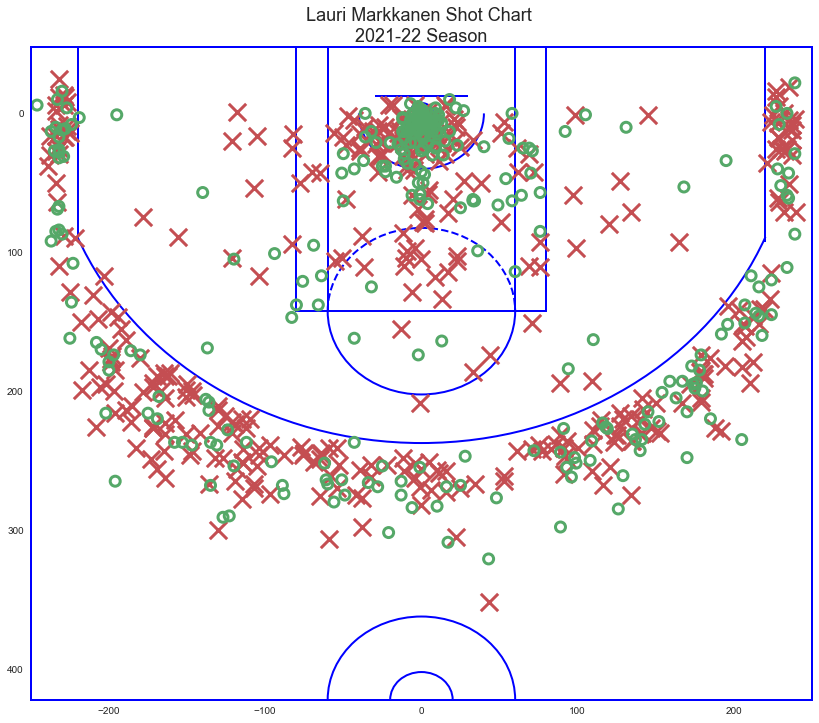

In [23]:
# First LM Shot Chart
shot_chart(player_shotchart_df, title='Lauri Markkanen Shot Chart \n2021-22 Season')
plt.show()

# HexMap - Lauri Markkanen

In [13]:
def sized_hexbin(ax, hc, hc2, cmap, norm):
    offsets = hc.get_offsets()
    orgpath = hc.get_paths()[0]
    verts = orgpath.vertices
    values1 = hc.get_array()
    values2 = hc2.get_array()
    ma = values1.max()
    patches = []

    for offset,val in zip(offsets,values1):
        # Adding condition for minimum size 
        # offset is the respective position of each hexagons
        
        # remove 0 to compare frequency without 0s
        filtered_list = list(filter(lambda num: num != 0, values1))
        
        # we also skip frequency counts that are 0s
        # this is to discount hexbins with no occurences
        # default value hexagons are the frequencies
        if (int(val) == 0):
            continue
        elif (percentileofscore(filtered_list, val) < 33.33):
            #print(percentileofscore(values1, val))
            #print("bot")
            v1 = verts*0.3 + offset
        elif (percentileofscore(filtered_list, val) > 69.99):
            #print(percentileofscore(values1, val))
            #print("top")
            v1 = verts + offset
        else:
            #print("mid")
            v1 = verts*0.6 + offset
        
        path = Path(v1, orgpath.codes)
        patch = PathPatch(path)
        patches.append(patch)

    pc = PatchCollection(patches, cmap=cmap, norm=norm)
    # sets color
    # so hexbin with C=data['FGP']
    pc.set_array(values2)

    ax.add_collection(pc)
    hc.remove()
    hc2.remove()

def hexmap_chart(data, league_avg, title="", color="b",
               xlim=(-250, 250), ylim=(422.5, -47.5), line_color="white",
               court_color="#1a477b", court_lw=2, outer_lines=False,
               flip_court=False, gridsize=None, 
               ax=None, despine=False, **kwargs):
    
    LA = league_avg.loc[:,['SHOT_ZONE_AREA','SHOT_ZONE_RANGE', 'FGA', 'FGM']].groupby(['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE']).sum()
    LA['FGP'] = 1.0*LA['FGM']/LA['FGA']
    player = data.groupby(['SHOT_ZONE_AREA','SHOT_ZONE_RANGE','SHOT_MADE_FLAG']).size().unstack(fill_value=0)
    player['FGP'] = 1.0*player.loc[:,1]/player.sum(axis=1)
    player_vs_league = (player.loc[:,'FGP'] - LA.loc[:,'FGP'])*100  

    data = pd.merge(data, player_vs_league, on=['SHOT_ZONE_AREA', 'SHOT_ZONE_RANGE'], how='right')
    
    if ax is None:
        ax = plt.gca()
        ax.set_facecolor(court_color)

    if not flip_court:
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    else:
        ax.set_xlim(xlim[::-1])
        ax.set_ylim(ylim[::-1])

    ax.tick_params(labelbottom="off", labelleft="off")
    ax.set_title(title, fontsize=18)

    # draws the court
    draw_court(ax, color=line_color, lw=court_lw, outer_lines=outer_lines)

    x = data['LOC_X']
    y = data['LOC_Y']
        
    # for diverging color map
    colors = ['#2b7cb6', '#abd9e9', '#ffffbf', '#fdaf61', '#d7191c', 'green']
    cmap = ListedColormap(colors)
    # The 5 colors are separated by -9, -3, 0, 3, 9
    boundaries = [-np.inf, -9, -3, 0, 3, 9, np.inf]
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)   
    
    # first hexbin required for bincount
    # second hexbin for the coloring of each hexagons
    hexbin = ax.hexbin(x, y, gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    hexbin2 = ax.hexbin(x, y, C=data['FGP'], gridsize=40, cmap=cmap, norm=norm, extent=[-275, 275, -50, 425])
    sized_hexbin(ax, hexbin, hexbin2, cmap, norm) 
    
    # Set the spines to match the rest of court lines, makes outer_lines
    # Somewhat unnecessary
    for spine in ax.spines:
        ax.spines[spine].set_lw(court_lw)
        ax.spines[spine].set_color(line_color)

    if despine:
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(False)

    return ax


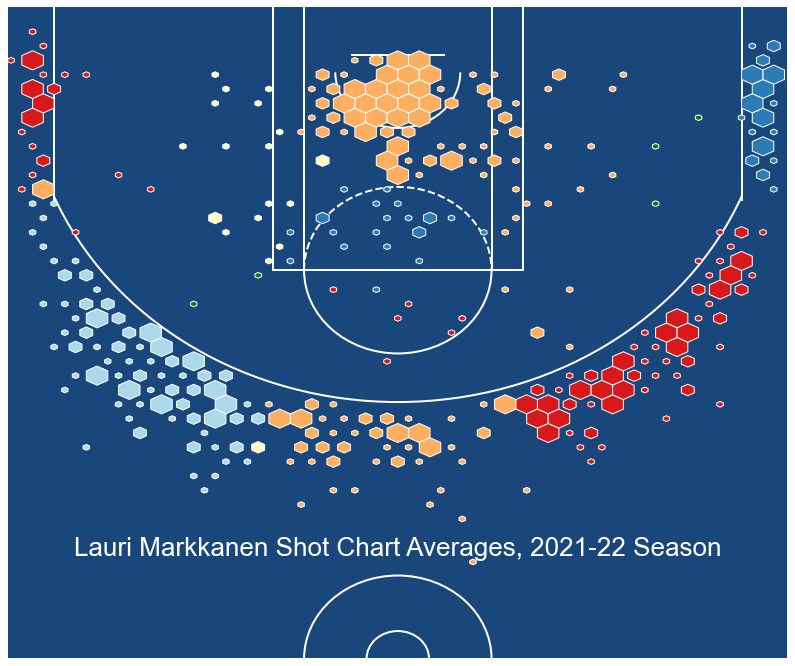

In [24]:
hexmap_chart(player_shotchart_df, league_avg, title='Lauri Markkanen \nHex Chart 2021-22 Season')
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)
plt.title('Lauri Markkanen Shot Chart Averages, 2021-22 Season', color='w', size=26, y=.15)
plt.show()

# 2022 Season

In [25]:
player_shotchart_df, league_avg = get_player_shotchartdetail('Lauri Markkanen', '2022-23')

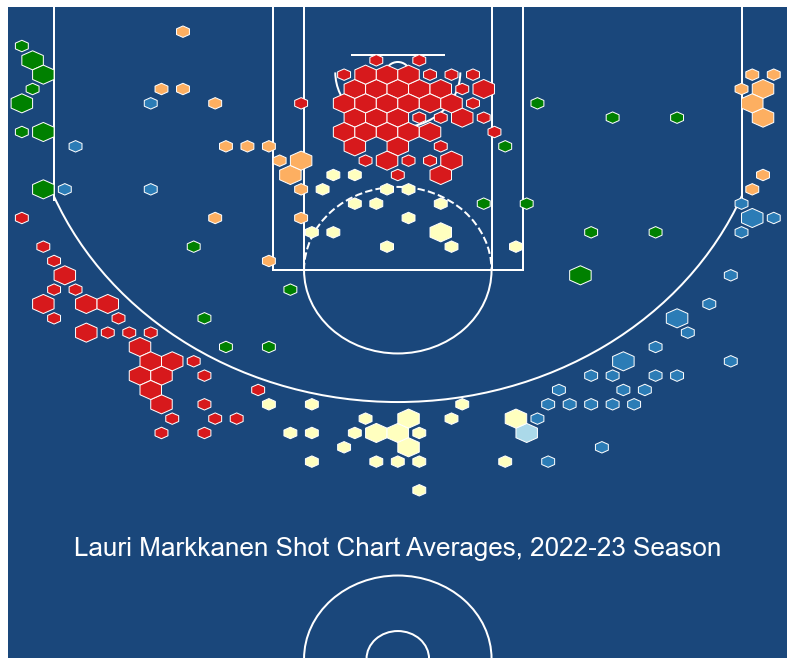

In [26]:
hexmap_chart(player_shotchart_df, league_avg, title='Lauri Markkanen \nHex Chart 2022-23 Season')
plt.tick_params(left=False, right=False, labelleft=False,
                labelbottom=False, bottom=False)
plt.title('Lauri Markkanen Shot Chart Averages, 2022-23 Season', color='w', size=26, y=.15)
plt.show()